In [23]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network applied on preselected feautre space from HCMC df_predictorsset, target variabels to predict are the relative commercial content losses [fraction of content loss and total content value ] of shophouses and their business reduction [% reduction in a month]

BN package: https://github.com/mike-mendoza/py_banshee

In [24]:
import sys, os
import logging
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


sys.path.insert(0, "../")
import utils.settings as s
import utils.figures as f


s.init()
seed = s.seed
pd.set_option('display.max_columns', None)
#plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')

target = "Target_businessreduction"

## save models and their evaluation in following folders:
Path(f"../../model_results/bayesian_network/businessreduction").mkdir(parents=True, exist_ok=True)


In [25]:
infile_name = "final_predictors_Target_businessreduction_10_1"
df_predictors = pd.read_excel(f"../model_results/selected_features/degree_of_loss/{infile_name}.xlsx")
print(df_predictors.shape)
print(df_predictors.tail(2))


(353, 17)
     Target_businessreduction  flowvelocity  emergency_measures   
351                       100           0.5            1.000000  \
352                       100           0.5            0.166667   

     water_depth_cm  bage  inundation_duration_h  shp_employees   
351            20.0  44.0                    5.0              1  \
352            40.0   3.0                    3.0              2   

     flood_experience  resilienceLeftAlone  shp_content_value_euro   
351               151                  3.5                  2283.2  \
352                76                  4.0                  2283.2   

     precautionary_measures_lowcost  b_area  resilience   
351                            0.50    50.0    1.666667  \
352                            0.25    80.0    4.000000   

     precautionary_measures_expensive  hh_monthly_income_euro   
351                          0.333333                   294.6  \
352                          0.333333                   294.6   

 

In [26]:
# ## find predictor with highest unconditional correlation to target
# # f.plot_spearman_rank(df_predictors)
# p = df_predictors.corr(method="spearman")
# plt.figure(figsize=(15,15))
# heatmap = sns.heatmap(df_predictors.corr(), 
#                       vmin=-1, vmax=1, 
#                       annot=True, fmt=".3f", 
#                       cmap="RdBu")

# # fv most corr ~ target

--> water depth and flow veloctiy correlate with same sthrength to Bred
therefore test both first based on their MAE score

In [64]:

# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(seed)

# Define name of output figure with BN; used by bn_visualize
fig_name = f'bn_{target}'


# Define the variable names
names_list = ['Target_businessreduction', 'flowvelocity', "emergency_measures", 'water_depth_cm', 
              'shp_employees', "resilienceLeftAlone", "precautionary_measures_lowcost", "flood_experience"]# "precautionary_measures_lowcost", "hh_monthly_income_euro", "b_area"]#, "flood_experience"]#, "shp_content_value_euro"]#"flood_experience"] #, 'b_area']#, 'inundation_duration_h']
# b_area bage income, inundation = no imporvement as 4th var
# NOTE barea precautionary_measures_lowcost inundation (flood_experience-stagnate)
# NOTE skip inundation_duration_h due that hadnt any improvemtn in other settings
print(df_predictors.columns)


# # Select the columns to use in the NPBN
df_predictors_bn = df_predictors[names_list]

names = {k: i for i, k in enumerate(names_list)}

print("Using following features:", names)

Index(['Target_businessreduction', 'flowvelocity', 'emergency_measures',
       'water_depth_cm', 'bage', 'inundation_duration_h', 'shp_employees',
       'flood_experience', 'resilienceLeftAlone', 'shp_content_value_euro',
       'precautionary_measures_lowcost', 'b_area', 'resilience',
       'precautionary_measures_expensive', 'hh_monthly_income_euro',
       'shp_avgmonthly_sale_euro', 'contaminations'],
      dtype='object')
Using following features: {'Target_businessreduction': 0, 'flowvelocity': 1, 'emergency_measures': 2, 'water_depth_cm': 3, 'shp_employees': 4, 'resilienceLeftAlone': 5, 'precautionary_measures_lowcost': 6, 'flood_experience': 7}


In [69]:
# Extract number of nodes from df_predictors
#N = 2 #11  # 3
N = df_predictors_bn.shape[1]  # number of nodes == number of features + target
print(N)

# Defining the structure of the BN
parent_cell = [None]*N

### --- Schema example --- ###
# parent_cell[0] = []           # climate (no parents)
# parent_cell[1] = [2]          # arts (parent node: recreation)
# parent_cell[4] = [1, 2, 3, 0] # target=safety (parents: all other variables)

### --- Schema kid_cell = parent_cells --- ###
parent_cell[0] = [1, 2, 3, 4, 5, 6, 7] #,4,5,6,7,8,9,10]                                                 #   target (parents: all other features)
parent_cell[1] = []     # NOTE recent modified, fv -> wd in bui                                                                # fv
parent_cell[2] = []#1, 3]                                                            # emerg  
parent_cell[3] = [1]                                                                      # wd  
parent_cell[4] = []                                                                      # employees  
parent_cell[5] = []                                                                  # resilienceLeftAlone
parent_cell[6] = []                                                                  # precautionary_measures_lowcost 
parent_cell[7] = [1,3]                                                                  # precautionary_measures_lowcost 

# ## 4 features  wd -> fv -> emerg, wd -> emer , employees -> emerg **
# ## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp -> emerg ***

## TODO read k-fold cv for BN eval?

## check conditional spearman correlations of features: eg. b_area (evtl as standalone feature)

## small buildage/area -> less capital, if owner: building age -> b area -> capital, if rent : capital-> building
## test change one arc --> eval model
## hint: start small BN with two var with most correlated feature (2 vars) --> 
## get highest coorelation values
## 3. hydro vars (check conditional correlation given the registed captial)

## if new var doesnt add anything to cond corr (change arc or rm var)

## stop until no imporvement ~ 5-6 nodes for target


parent_cell

8


[[1, 2, 3, 4, 5, 6, 7], [], [], [1], [], [], [], [1, 3]]

<Figure size 500x500 with 0 Axes>

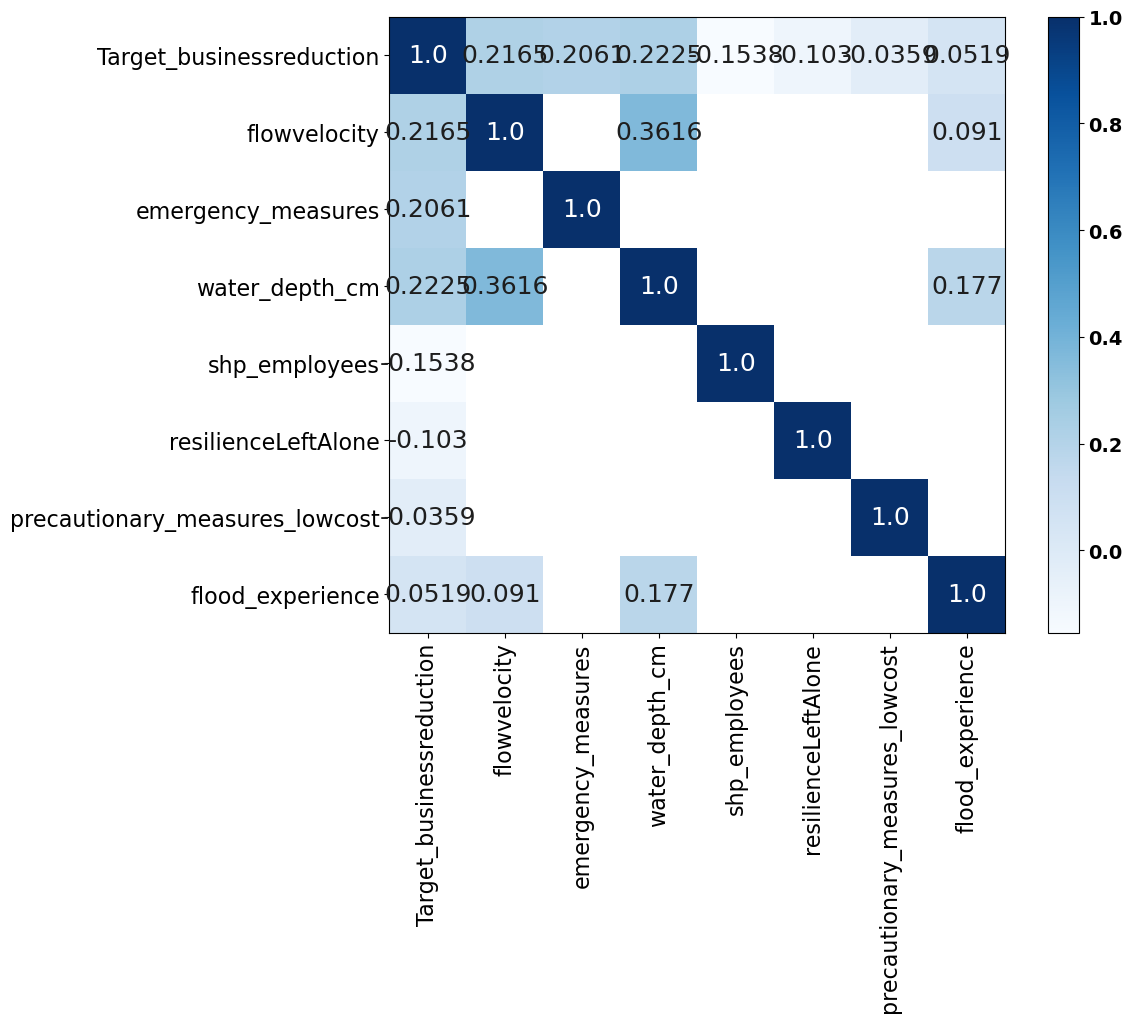

In [70]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

plt.figure(figsize=(5,5))
R = bn_rankcorr(parent_cell,        # structure of the BN
                df_predictors_bn,   # matrix of df_predictors
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don't create plot)

# The plot shows that target has the strongest correlation with water_barriers_impl,
# then the conditional correlation with flowveloctity (but maybe only due to strong correlation with water_depth and inundation_duration ). The conditional 
# correlations with with xx and xxx are weaker. Between other 
# variables, there is strong dependency between shp_registered_capital and shp_avg_monhtly_sale.

# precaution -0.0456 ** (no matter if pre-> wd or wd -> prec)

In [71]:
# cv = cross_validate(model, X, y, cv=30)
# print(f"scores with cross-folding : {cv['test_score']}")
# print()

# print(f"mean score : {cv['test_score'].mean()}")


In [72]:
#-----------------------------------------------------------------------------
# Function 5 - inference - making inference with the BN model
#-----------------------------------------------------------------------------

condition=[1, 2, 3, 4, 5, 6, 7] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_predictors_bn.iloc[:,condition].to_numpy() # df_predictors for conditionalization

F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the
                                # nodes of the NPBN
              R,                # the rank correlation matrix 
              df_predictors_bn, # df_predictorsFrame with df_predictors
             # Output='mean')    # type of output df_predictors
              Output='median')    # type of output df_predictors

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

## predict target
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_original=df_predictors_bn.iloc[:,0].to_numpy()

# Calculate coefficient of determination
A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
B = (y_original - y_original.mean(axis=0))/y_original.std(axis=0)
correlation = (np.dot(B, A.T)/B.shape[0])
R2=correlation**2

# Calculate evaluation metrics
MAE = np.mean(np.abs(y_pred-y_original))
MBE = np.mean(y_pred-y_original)
RMSE = (np.mean((y_pred-y_original)**2))**(1/2)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  


Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  2%
Making inference. Progress:  2%
Making inference. Progress:  2%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  4%
Making inference. Progress:  4%
Making inference. Progress:  4%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  8%
Making inference. Progress:  8%
Making i

Making inference. Progress:  16%
Making inference. Progress:  17%
Making inference. Progress:  17%
Making inference. Progress:  17%
Making inference. Progress:  18%
Making inference. Progress:  18%
Making inference. Progress:  18%
Making inference. Progress:  18%
Making inference. Progress:  19%
Making inference. Progress:  19%
Making inference. Progress:  19%
Making inference. Progress:  20%
Making inference. Progress:  20%
Making inference. Progress:  20%
Making inference. Progress:  20%
Making inference. Progress:  21%
Making inference. Progress:  21%
Making inference. Progress:  21%
Making inference. Progress:  22%
Making inference. Progress:  22%
Making inference. Progress:  22%
Making inference. Progress:  22%
Making inference. Progress:  23%
Making inference. Progress:  23%
Making inference. Progress:  23%
Making inference. Progress:  24%
Making inference. Progress:  24%
Making inference. Progress:  24%
Making inference. Progress:  24%
Making inference. Progress:  25%
Making inf

In [32]:
## resilneceLeftAlon
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA ***
# MAE, MBE, RMSE, R2: 17.200156373937677 0.4218543909348444 23.15446102273047 0.10639659042647506
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, employees -> resilLA (sm shp feel left alon) ***
# MAE, MBE, RMSE, R2: 17.176264589235128 0.4530617563739379 23.124443137322782 0.108357373657999
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, employees -> resilLA -> emerg
# MAE, MBE, RMSE, R2: 17.1957447592068 0.5416563739376764 23.123202603045744 0.10895224317309785

## resilience  + precaution
## 6  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA, prec_cheap *********
# MAE, MBE, RMSE, R2: 17.027345609065158 -0.01665269121813176 23.048158649799895 0.11250114114029462
## 6  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA -> prec_cheap,  *********
# MAE, MBE, RMSE, R2: 17.025917847025497 -0.04757223796034028 23.049739182418246 0.11223725255180217

## 6  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA, prec_cheap -> wd
# MAE, MBE, RMSE, R2: 17.03888611898017 -0.029772237960340845 23.053894013392544 0.11193013239781474
                                                                

In [336]:
## bred for CanTHo (all sectors)
## 1 feature (fv) (predictor with strongest unconditional correlation to target)
# MAE, MBE, RMSE, R2: 19.505287818696882 3.023567138810198 24.160341209664693 0.04181915781958483

## 2 features (fv , eme): 
# MAE, MBE, RMSE, R2: 19.74858300283286 4.847018130311617 24.102795696439568 0.07470495711283799
## 2 features (fv -> eme):  **
# MAE, MBE, RMSE, R2: 19.50758866855524 4.4753994334277625 23.847507546059752 0.08311888467028201


## 3 features (fv -> eme, wd): 
# MAE, MBE, RMSE, R2: 19.812639376770537 4.699533994334278 24.505799118556922 0.05333127112893681
# (fv, wd) -> emer                                                                
# MAE, MBE, RMSE, R2: 19.681899150141643 5.419263456090651 24.4689403027466 0.0773554306974711
## 3 features (wd -> fv -> eme): 
# MAE, MBE, RMSE, R2: 19.35493597733711 4.44363059490085 24.164246571908436 0.07249607165736519
# wd -> fv -> emerg, wd -> emer    **
# MAE, MBE, RMSE, R2: 19.268610198300284 4.345695750708216 24.10171438023097 0.07410980916779679

## 4 features  wd -> fv -> emerg, wd -> emer , bage OR wd -> fv -> emerg, wd -> emer, bage -> emer 
# MAE, MBE, RMSE, R2: 22.523064589235126 9.747832861189801 30.487814466673964 0.04561359169218263

## 4 features  wd -> fv -> emerg, wd -> emer , employees 
# MAE, MBE, RMSE, R2: 18.175970538243625 1.9748232294617563 23.62099298041095 0.0823823705515876

## 4 features  wd -> fv -> emerg, wd -> emer , employees -> emerg **
# MAE, MBE, RMSE, R2: 18.114451558073654 2.0018022662889505 23.521324314751425 0.08837952332919242


## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp
# MAE, MBE, RMSE, R2: 18.15713569405099 1.9102444759206798 23.624181609497047 0.08180727515554582
## 5  features  wd -> fv -> emerg, wd -> emer , f_exp -> employees -> emerg **
# MAE, MBE, RMSE, R2: 18.083003966005666 1.9070526912181294 23.52099952528106 0.08762798639808682
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp -> emerg **
# MAE, MBE, RMSE, R2: 18.02483654390935 1.8803764872521245 23.47399253197319 0.09032304789434419

# 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp
# MAE, MBE, RMSE, R2: 18.15713569405099 1.9102444759206798 23.624181609497047 0.08180727515554582
## 5  features  wd -> fv -> emerg, wd -> emer , f_exp -> employees -> emerg **
# MAE, MBE, RMSE, R2: 18.083003966005666 1.9070526912181294 23.52099952528106 0.08762798639808682

## NOTE flood_experience destn had much to the correlation matrix
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp -> emerg ***
# MAE, MBE, RMSE, R2: 18.02483654390935 1.8803764872521245 23.47399253197319 0.09032304789434419
# MAE, MBE, RMSE, R2: 18.049626912181303 1.9718960339943339 23.472259684081735 0.09114064236879915

## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, wd -> f_exp  or (fv, wd ) -> f_exp
# MAE, MBE, RMSE, R2: 18.04273852691218 1.8733560906515578 23.485209176707 0.08947400855478219
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, empyees -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.151970254957504 2.005811614730878 23.605126298988313 0.08341479771829687
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, fv -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.087845042492916 1.9727124645892347 23.54767208649904 0.08669006220384032
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, (fv, wd) -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.033663456090654 1.906552407932011 23.483206802412496 0.090087138456569
# MAE, MBE, RMSE, R2: 18.07102379603399 1.963625495750708 23.48455980772728 0.09018022497710662
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp
# MAE, MBE, RMSE, R2: 18.15713569405099 1.9102444759206798 23.624181609497047 0.08180727515554582
## 5  features  wd -> fv -> emerg, wd -> emer , f_exp -> employees -> emerg **
# MAE, MBE, RMSE, R2: 18.083003966005666 1.9070526912181294 23.52099952528106 0.08762798639808682
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, empyees -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.151970254957504 2.005811614730878 23.605126298988313 0.08341479771829687
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, fv -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.087845042492916 1.9727124645892347 23.54767208649904 0.08669006220384032

## NOTE flood_experience doestn add much to the correlation matrix . corr ~ 0.02
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp -> emerg **
# MAE, MBE, RMSE, R2: 18.02483654390935 1.8803764872521245 23.47399253197319 0.09032304789434419
# MAE, MBE, RMSE, R2: 18.049626912181303 1.9718960339943339 23.472259684081735 0.09114064236879915
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, wd -> f_exp  or (fv, wd ) -> f_exp
# MAE, MBE, RMSE, R2: 18.04273852691218 1.8733560906515578 23.485209176707 0.08947400855478219
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, (fv, wd) -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.033663456090654 1.906552407932011 23.483206802412496 0.090087138456569
# MAE, MBE, RMSE, R2: 18.07102379603399 1.963625495750708 23.48455980772728 0.09018022497710662

## NOTE decrease in BN by adding barea or content value as 5th var (insted f exp)


In [ ]:
## bred for HCMC (all sectors)

## 1 feature (fv) (predictor with strongest unconditional correlation to target)
# MAE, MBE, RMSE, R2: 19.505287818696882 3.023567138810198 24.160341209664693 0.04181915781958483

## 2 features (fv , wd): 
#MAE, MBE, RMSE, R2: 19.666353824362606 4.0971328611898015 24.724952060748617 0.0445429230009319
## 2 features (fv -> wd):
# MAE, MBE, RMSE, R2: 19.27965014164306 3.0124597733711056 24.42307087930957 0.03853784201023082
## 2 features (wd -> fv): *** 
# MAE, MBE, RMSE, R2: 19.19400849858357 3.0263410764872525 24.32564070748576 0.04346755981646989

## 3 features (fv -> wd, ind) or 3 features (fv -> wd, ind-> wd): 
# MAE, MBE, RMSE, R2: 19.85800424929178 3.829028611898017 26.26434191775025 0.021068001106892515
## 3 features (inund -> fv -> wd): 
# MAE, MBE, RMSE, R2: 20.061832861189803 4.209602266288951 26.296466395722444 0.022958052067840833
## 3 features (fv -> inund -> wd) or (fv -> wd -> inund): 
# MAE, MBE, RMSE, R2: 20.360632577903683 5.158526628895184 26.629869881681152 0.028134408947895335
## 3 features (fv -> wd, f_exp): 
# MAE, MBE, RMSE, R2: 19.49173371104816 3.5954328611898014 24.485946638578397 0.04108387664484545
## 3 features (fv -> wd, fv -> f_exp) or (fv -> wd, wd -> f_exp): 
# MAE, MBE, RMSE, R2: 19.437306232294617 3.5750371104815866 24.4236399033457 0.04324104053604041
# MAE, MBE, RMSE, R2: 19.4146730878187 3.5007552407932008 24.4052399553994 0.04337155544398731

## 3 features (fv -> wd, b area): 
# MAE, MBE, RMSE, R2: 19.694199716713882 3.3882450424929176 25.499697335228188 0.016091008515160106
## 3 features (b area -> fv -> wd, ) or ( (b area, fv) -> wd, )
# MAE, MBE, RMSE, R2: 19.644013597733707 3.452292351274788 25.443190103627895 0.018462419021187275
# MAE, MBE, RMSE, R2: 19.632755524079318 3.3500699716713886 25.43108857960936 0.01756801044079168


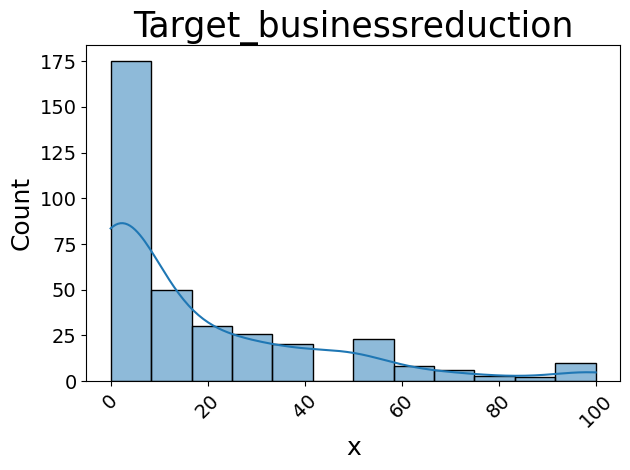

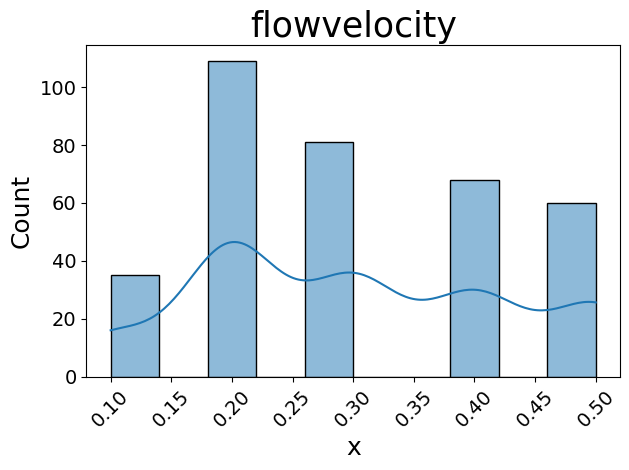

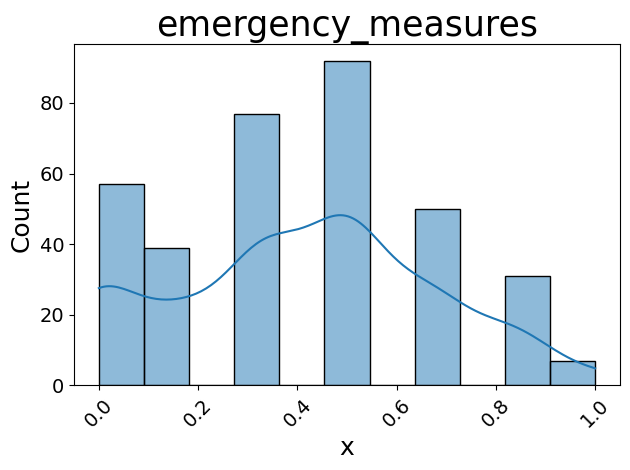

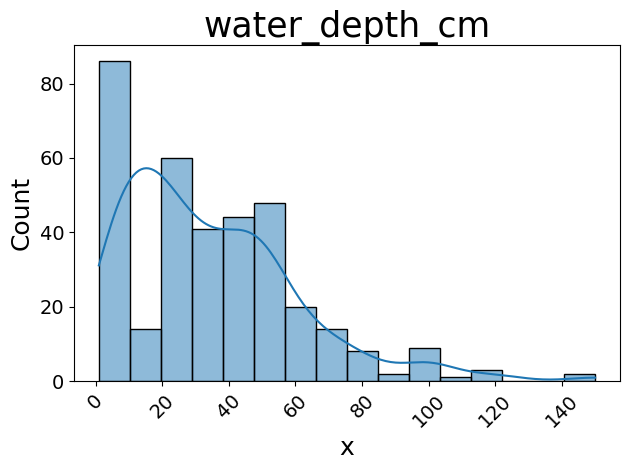

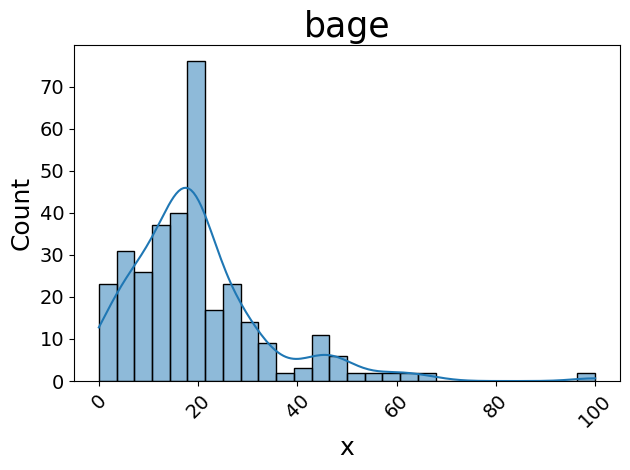

'BN plot saved in : c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\bayesian_networks\\BN_visualize_bn_Target_businessreduction_margins.pdf'

In [ ]:
#-----------------------------------------------------------------------------
# Function 2 - bn_visualize - Plot of the Bayesian Network
#-----------------------------------------------------------------------------

bn_visualize(parent_cell,           # structure of the BN
             R,                     # the rank correlation matrix (function 1)
             df_predictors.columns,          # names of variables
             fig_name = fig_name)   # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs.

bn_visualize(parent_cell,                       # structure of the BN
             R,                                 # the rank correlation matrix 
             df_predictors.columns,                      # names of variables
             df_predictors = df_predictors,                       # df_predictorsFrame with df_predictors
             fig_name = fig_name + '_margins')  # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs. In this plot also the marginal
# distributions for each variable are incorporated.


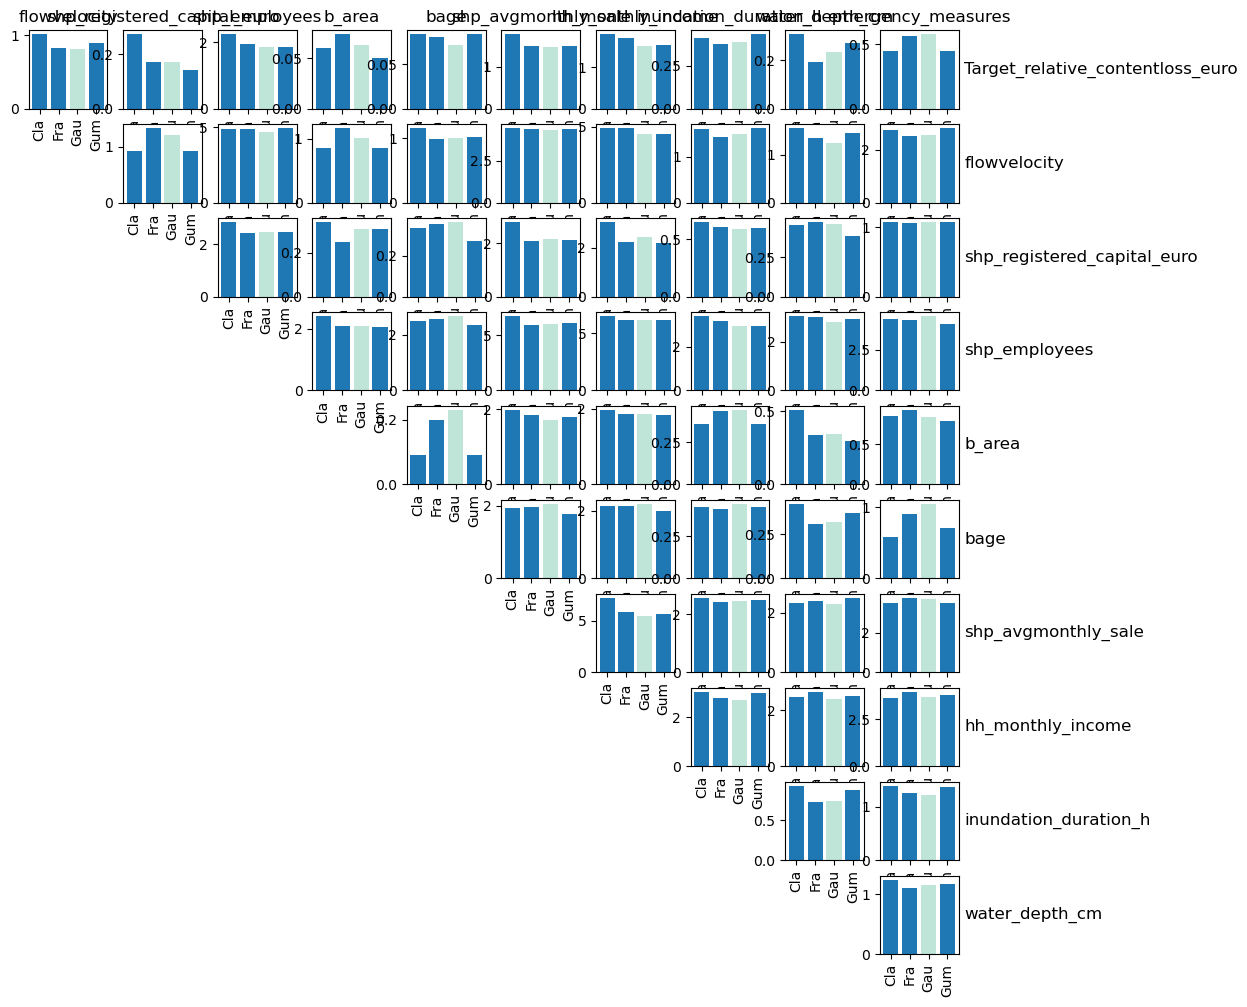

In [ ]:
#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------

M = cvm_statistic(df_predictors,                   # df_predictorsFrame with df_predictors
                  names = df_predictors.columns,   # names of variables
                  plot = True,               # create a plot (0=don't create plot)
                  fig_name = fig_name)    # figure name
                  
# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.


## !! decalibration score = overall score if BN fullfills 

In [ ]:
M

,Var1,Var2,r,Clayton,Frank,Gaussian,Gumbel
0,Target_relative_contentloss_euro,flowvelocity,0.263828,1.014663,0.829228,0.816773,0.895479
1,Target_relative_contentloss_euro,shp_registered_capital_euro,0.273843,0.274814,0.169969,0.170619,0.142091
2,Target_relative_contentloss_euro,shp_employees,0.105858,2.250071,1.940503,1.860467,1.845609
3,Target_relative_contentloss_euro,b_area,-0.045066,0.060234,0.074083,0.06343,0.049957
4,Target_relative_contentloss_euro,bage,-0.266082,0.084048,0.080713,0.071532,0.084046
5,Target_relative_contentloss_euro,shp_avgmonthly_sale,0.283974,1.788844,1.506169,1.479901,1.494931
6,Target_relative_contentloss_euro,hh_monthly_income,0.119853,1.798456,1.69679,1.497202,1.540063
7,Target_relative_contentloss_euro,inundation_duration_h,0.19021,0.41297,0.376379,0.389603,0.434001
8,Target_relative_contentloss_euro,water_depth_cm,0.413043,0.307181,0.190514,0.233761,0.269286
9,Target_relative_contentloss_euro,emergency_measures,0.125531,0.447025,0.566304,0.579871,0.447029


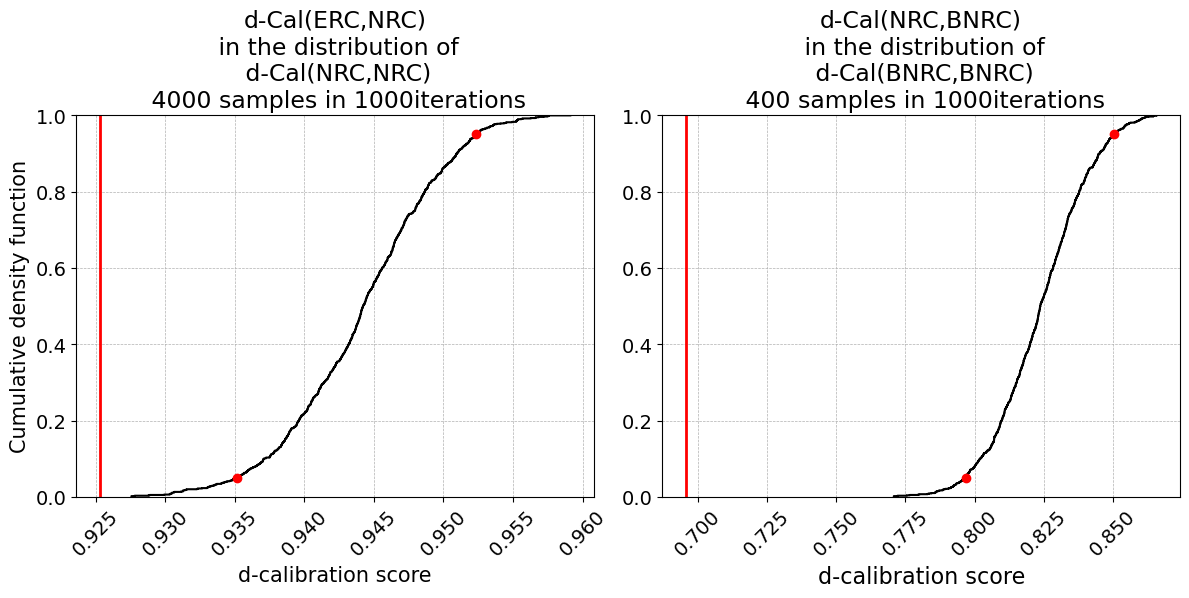

FAILURE: The d-Cal of the empirical rank correlation matrix (ERC) is out of the confidence intervals of the d-Cal of the normal rank correlation matrix (NRC)

FAILURE: The d-Cal of the normal rank correlation matrix (NRC) is out of the confidence intervals of the d-Cal of the BN rank correlation matrix (BNRC)



In [ ]:
#-----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
#-----------------------------------------------------------------------------

## TODO fix np.mul() --> fixed with np.mulitply() in d_cal.py from py_banshee package ~ 1h
## try to fix, otherwise write with CC Dominik (maybe mixed up respective matlab func()--> )

# gaussian_distance : validation: 
D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
                            R,        # the rank correlation matrix 
                            df_predictors,     # df_predictorsFrame with df_predictors
                            4000,     # number of samples drawn d-Cal(ERC,NRC)
                            400,      # number of samples drawn d-Cal(NRC,BNRC)
                            1000,     # number of iterations to compute CI
                            Plot=True,          # create a plot (0=don't create plot)
                            Type='H',           # take Hellinger distance (default)
                            fig_name=fig_name)  # figure name

                        
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the empirical rank correlation matrix is
# inside the 90# confidence interval of the determinant of the empirical
# The d-calibration score of the BN's rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large df_predictorssets.


In [ ]:
df_predictors.head(2)#.shape

,Target_relative_contentloss_euro,shp_registered_capital_euro,flowvelocity,shp_employees,shp_avgmonthly_sale_cat,water_barriers_impl,b_area,pumping_equipment_impl,water_depth_cm,hh_monthly_income_cat,inundation_duration_h
7,0.002289,3682.6,2,2,4,5,54.0,5,20,7.0,12.0
9,0.001999,441.9,4,2,1,1,45.0,5,3,3.0,2.0


## Evaluation

In [ ]:
## predict target
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_original=df_predictors.iloc[:,0].to_numpy()

# Calculate coefficient of determination
A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
B = (y_original - y_original.mean(axis=0))/y_original.std(axis=0)
correlation = (np.dot(B, A.T)/B.shape[0])
R2=correlation**2

# Calculate evaluation metrics
MAE = np.mean(np.abs(y_pred-y_original))
MBE = np.mean(y_pred-y_original)
RMSE = (np.mean((y_pred-y_original)**2))**(1/2)

print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  


In [ ]:
# from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold, cross_validate, cross_val_predict


# cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)

# scores = cross_validate(   # allows specifying multiple metrics for evaluation comparated to cross_val_score
#     F, 
#     df_predictors.iloc[:,condition], y_original, 
#     # return_train_score=  # if True: more computanitonal expensive, gives scores of training sets
#     scoring="neg_MAE",# "neg_mean_absolute_error",,  # Strategy to evaluate the performance of the cross-validated model on the test set.
#     cv=cv, 
#     n_jobs=-1
# ) 


In [ ]:

# first try: MAE, MBE, RMSE, R2: 0.22737828120590867 0.18693083465146496 0.4326010916688961 1.055515193816181e-05
# -> moderate overestimation of BN model, stronger overall 


# The coefficient of determination between modelled and observed target 
# is xxx, but the average error (mae: 0.227) is much higher than
# the average value of the response (mean: 0.056), and there is some overestimation bias.
# However, for proper validation, if sufficient df_predictors is available, a split-
# -sample validation or a k-fold cross-validation should be performed.

## see how small BN performs than expanded by further variables and check performance


####################################################
############ python meeting #############
## PDP
## google colab #  r - py combine :  
## y_pred , permutation -which fetures/or one feature
## pytorch, keras <-->  R, 
## explore() compare two maps- zomm in --> linked maps

MAE, MBE, RMSE, R2: 0.22737828120590867 0.18693083465146496 0.4326010916688961 1.055515193816181e-05


In [ ]:
#?RepeatedKFold

InvalidParameterError: The 'estimator' parameter of cross_validate must be an object implementing 'fit'. Got array([[ 0.16347476],
       [ 0.01371408],
       [ 0.01816009],
       [ 0.16722744],
       [ 1.1       ],
       [ 0.10879648],
       [ 0.05607578],
       [ 0.05824835],
       [ 0.05476475],
       [ 0.02918989],
       [ 1.1       ],
       [ 1.1       ],
       [ 1.1       ],
       [ 1.1       ],
       [ 0.39124636],
       [ 0.11123776],
       [ 1.1       ],
       [-0.00326076],
       [ 0.07375042],
       [ 0.00628686],
       [ 0.03791784],
       [ 0.09739452],
       [ 0.02054741],
       [ 0.09661246],
       [ 0.14391711],
       [ 0.14089535],
       [ 1.1       ],
       [ 0.10328404],
       [ 0.39148823],
       [ 1.1       ],
       [ 0.07732154],
       [ 0.07326568],
       [ 0.36064486],
       [ 0.04081759],
       [ 0.02596857],
       [ 0.02815278],
       [ 0.05071997],
       [ 1.1       ],
       [ 0.04151131],
       [ 0.18314016],
       [ 0.0260848 ],
       [ 0.04534307],
       [ 0.02867887],
       [ 0.14498903],
       [ 0.05158406],
       [ 0.0069605 ],
       [ 0.09133098],
       [ 0.35257486],
       [ 0.21644883],
       [ 0.48579645],
       [ 0.11176638],
       [ 0.0123673 ],
       [ 1.1       ],
       [ 0.10776571],
       [ 0.06499087],
       [ 0.02842233],
       [ 0.01551382],
       [ 0.04945894],
       [ 0.13813305],
       [ 0.02489687],
       [ 0.07140658],
       [ 0.1064993 ],
       [ 0.093665  ],
       [ 0.01560742],
       [ 0.01974605],
       [ 0.00119183],
       [ 0.33555809],
       [ 0.13194573],
       [ 0.14211835],
       [ 1.1       ],
       [ 0.03241035],
       [ 0.03332841],
       [ 0.02512826],
       [ 0.04624671],
       [ 0.15451778],
       [ 0.02223136],
       [ 1.1       ],
       [ 0.04054287],
       [ 0.04385087],
       [ 0.16462748],
       [ 0.05035138],
       [ 0.03579053],
       [ 0.04792825],
       [ 0.05488011],
       [ 0.0561095 ],
       [ 0.0721532 ],
       [ 0.09131888],
       [ 0.33916393],
       [ 1.1       ],
       [ 1.1       ],
       [ 1.1       ],
       [ 0.18749771],
       [ 0.00866714],
       [ 0.49233727],
       [ 1.1       ],
       [ 0.00453687],
       [ 0.06770779],
       [ 0.08878729],
       [ 0.05905354],
       [ 0.14513796],
       [ 0.0630918 ],
       [ 0.23027807],
       [ 0.07353641],
       [ 0.1260419 ],
       [ 0.0365882 ],
       [ 0.09649585],
       [ 0.37966558],
       [ 1.1       ],
       [ 0.1216051 ],
       [ 0.09615853],
       [ 1.1       ],
       [ 0.12882772],
       [ 1.1       ],
       [ 0.10484207],
       [ 0.05350656],
       [ 0.07701947],
       [ 0.08809262],
       [ 0.18519853],
       [ 0.08644923],
       [ 0.06549602],
       [ 0.02680212],
       [ 0.09621977],
       [ 0.02235033],
       [ 0.11973015],
       [ 0.0831287 ],
       [ 0.03544015],
       [ 0.01996047],
       [ 0.01501593],
       [ 0.15230103],
       [ 0.22635867],
       [ 0.04911022],
       [ 0.03046738],
       [ 0.08326517]]) instead.

In [ ]:
df_predictors[target].describe()


count    133.000000
mean       0.056082
std        0.144453
min        0.000254
25%        0.003557
50%        0.010001
75%        0.029121
max        1.000000
Name: Target_relative_contentloss_euro, dtype: float64

In [ ]:
df_predictors[target].describe()


count    133.000000
mean       0.056082
std        0.144453
min        0.000254
25%        0.003557
50%        0.010001
75%        0.029121
max        1.000000
Name: Target_relative_contentloss_euro, dtype: float64

In [ ]:
# cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)
      
# ## outer cv for evaluation metrics (averaged across outer folds)
# scores = cross_validate(   # allows specifying multiple metrics for evaluation comparated to cross_val_score
#     model, 
#     X, y, 
#     scoring=["accuracy", "precision", "recall", "f1"],  # Strategy to evaluate the performance of the cross-validated model on the test set.
#     cv=cv, 
# ) 
# print("outer CV: ACC: %.3f (%.3f)"%(scores["test_accuracy"].mean(), np.std(scores["test_accuracy"])))
# print("outer CV: precision: %.3f (%.3f)"%(scores["test_precision"].mean(), np.std(scores["test_precision"])))
# print("outer CV: recall: %.3f (%.3f)"%(scores["test_recall"].mean(), np.std(scores["test_recall"])))